<a href="https://colab.research.google.com/github/snghynn/handsonml/blob/main/concept_%ED%95%A9%EC%84%B1%EA%B3%B14_%EC%9D%B4%EB%AF%B8%EC%A7%80%EB%B6%84%ED%95%A0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



파이썬 딥러닝 텐서플로 ch4.7

pg. 229 ~ 240


## 4.7 이미지 분할

- 이미지 분할(Segmentation): 이미지를 구성하는 모든 픽셀에 대해 픽셀 단위로 분류하는 것
- 픽셀은 클래스에 속함 (eg, 배경 클래스와 객체 클래스로 구성된 이미지가 있다면, 모든 픽셀은 배경 또는 객체 중 하나로 분류됨)

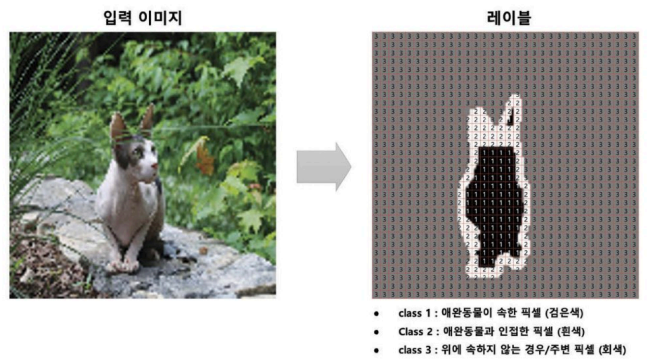

- 이미지 분할의 구분
  - 의미 분할(semantic segmentation): 같은 범주의 여러 객체를 하나의 범주로 묶어서 구분
  - 인스턴스 분할(instance segmentation): 같은 범주에 속하더라도 서로 다른 객체를 구분


  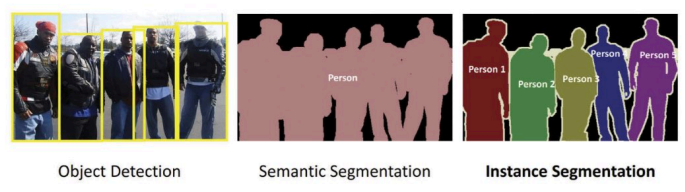


## 7-1 데이터셋 준비
- Oxford-IIIT Pet Dataset
  - 반려동물의 이미지 및 분류 레이블, 각 이미지를 구성하는 픽셀 단위의 마스크로 구성
  - 마스크: 각 픽셀에 대한 범주 레이블
- 각 픽셀은 세 가지 범주 중 하나에 속함
  - class 1: 반려동물이 속한 픽셀(노란색 영역)
  - class 2: 반려동물과 인접한 픽셀(빨간색 영역)
  - class 3: 위에 속하지 않는 경우/주변 픽셀(파란색 영역)

 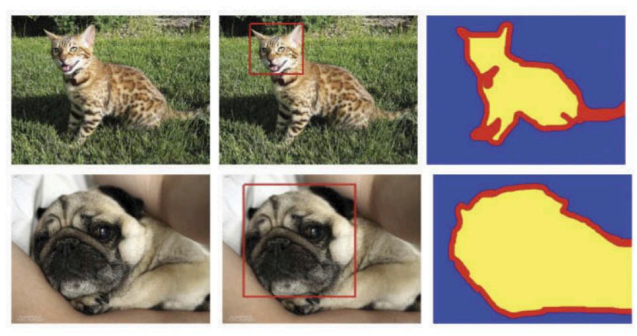

In [1]:
# library import
import numpy as np
import tensorflow as tf
import matplotlib.pylab as plt
import cv2
from tqdm.notebook import tqdm
import tensorflow_datasets as tfds
from google.colab.patches import cv2_imshow

In [2]:
# 입력 이미지의 크기와 학습 파라미터 설정
# 이미지 크기
img_w = 128
img_h = 128
img_c = 3
img_shape = (img_w,img_h,img_c)

# 모델 학습
epoch_num = 3
learning_rate = 0.0001
buffer_size = 1000
batch_size = 16

In [3]:
# 텐서플로 데이터셋에서 옥스포드 반려동물 데이터 불러오기
ds_str = 'oxford_iiit_pet'
ds, info = tfds.load(name=ds_str, with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete9NV12L/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete9NV12L/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [4]:
# 원본 이미지와 분할 마스크를 전처리하는 함수 정의
# 이미지 전처리 함수
def preprocess_image(ds):
  # 원본 이미지
  img = tf.image.resize(ds['image'],(img_w, img_h))
  img = tf.cast(img, tf.float32)/255.0 # 픽셀을 255로 나누어 0~1 범위로 정규화
  # 분할 마스크
  mask = tf.image.resize(ds['segmentation_mask'],(img_w, img_h))
  mask = tf.cast(mask, tf.int32)
  mask = mask-1 # 마스크가 0,1,2 정수형 값을 갖도록 1 차감
  return img, mask

In [5]:
# 데이터 전처리 함수를 훈련셋, 테스트셋에 매핑 후 미니배치로 분할
train_ds = ds['train'].map(preprocess_image).shuffle(buffer_size).batch(batch_size).prefetch(2)
test_ds = ds['test'].map(preprocess_image).shuffle(buffer_size).batch(batch_size).prefetch(2)

print(train_ds)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.int32, name=None))>


In [6]:
# 샘플 배치 선택
img, mask = next(iter(train_ds))
len(img) # 배치에는 16개의 샘플 이미지와 마스크 이미지가 들어있음

16

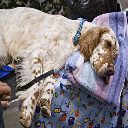

In [7]:
# 배치에서 첫번째 이미지 출력
img = np.array(img[0]) * 255.0 # 앞서 정규화한 것 복원
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
cv2_imshow(img)

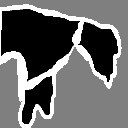

In [8]:
# 샘플 마스크 출력
mask = (np.array(mask[0])/2) * 255.0
cv2_imshow(mask)

## 7-2 U-Net 모델(인코더-디코더)


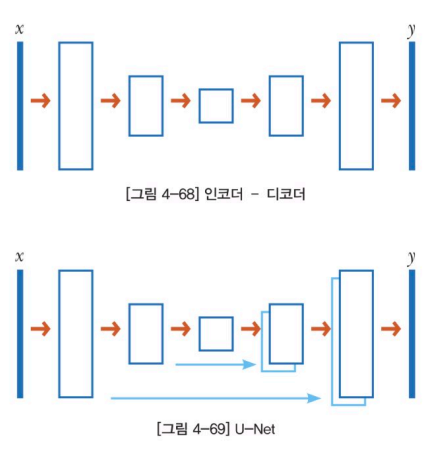

- U-Net 모델: 사전 학습된 VGG16모델을 인코더로 활용
- 전이학습방법 사용: 제한된 자원으로 양호한 성능을 갖는 모델을 만들기 위해 사전 학습된 모델을 베이스모델로 활용


In [9]:
# VGG16 모델 불러오기(최종 레이어 제외한 채로)
base_model = tf.keras.applications.VGG16(input_shape=img_shape, include_top=False)

58889256/58889256 [==============================] - 0s 0us/step


- VGG16 모델은 합성곱 층과 풀링 층을 직렬로 연결한 구조
- (128,128) 크기의 텐서가 마지막 레이어에서는 (4,4) 크기로 축소됨
- 이 모델을 U-Net의 인코더로 사용
- 인코더: 워본 이미지 중에서 같은 범주에 속하는 픽셀을 결합하면서 점진적으로 이미지를 더 작은 크기로 축소
- 마스크 정답을 활용해 각 픽셀의 마스크 범주를 0,1,2 중에서 하나로 분류하는 역할

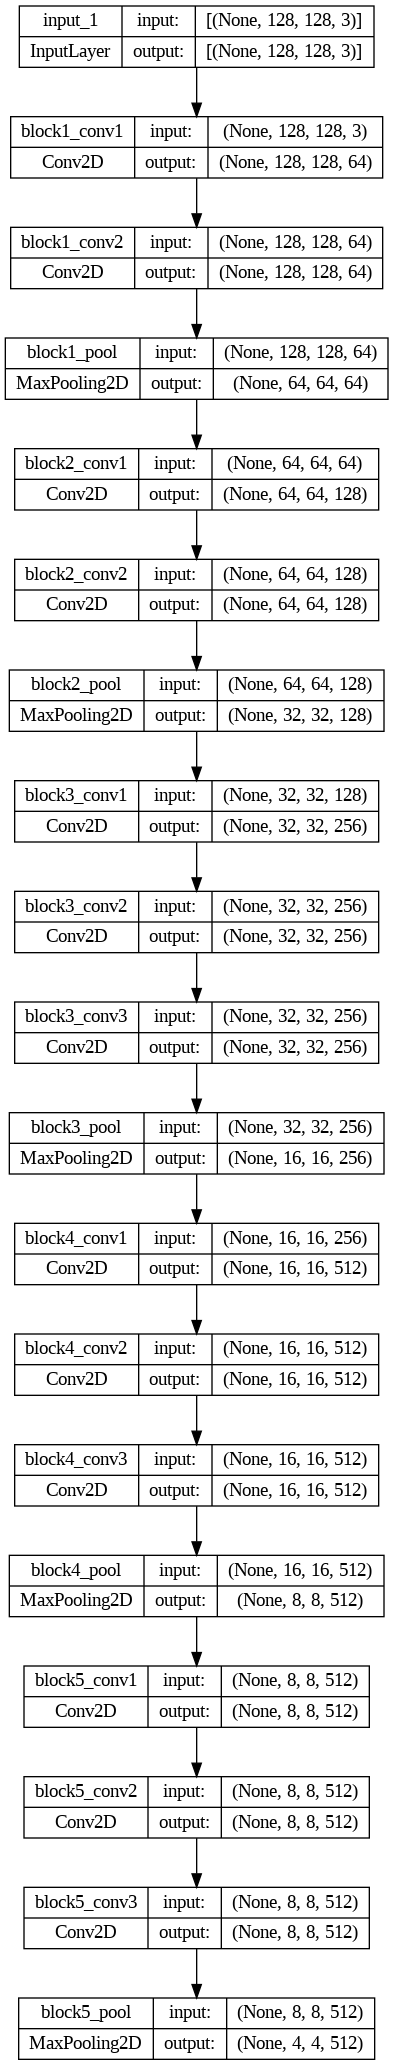

In [10]:
# 모델 구조
tf.keras.utils.plot_model(base_model, show_shapes=True)

In [11]:
# VGG16 중간 레이어 출력 텐서를 지정
f_model = tf.keras.Model(inputs=[base_model.input],
                         outputs=[
                             base_model.get_layer(name='block5_conv3').output,
                             base_model.get_layer(name='block4_conv3').output,
                             base_model.get_layer(name='block3_conv3').output,
                             base_model.get_layer(name='block2_conv2').output,
                             base_model.get_layer(name='block1_conv2').output,
                         ])

In [12]:
# 파라미터 고정
f_model.trainable=False

In [13]:
# U-Net 구조로 모델 정의
i = tf.keras.Input(shape=img_shape)

out_8_8_512, out_16_16_512, out_32_32_256, out_64_64_128,out_128_128_64 = f_model(i)

out = tf.keras.layers.Conv2DTranspose(512,3,strides=2,padding='same')(out_8_8_512)
out = tf.keras.layers.Add()([out, out_16_16_512])

out = tf.keras.layers.Conv2DTranspose(256,3,strides=2,padding='same')(out)
out = tf.keras.layers.Add()([out, out_32_32_256])

out = tf.keras.layers.Conv2DTranspose(128,3,strides=2,padding='same')(out)
out = tf.keras.layers.Add()([out, out_64_64_128])

out = tf.keras.layers.Conv2DTranspose(64,3,strides=2,padding='same')(out)
out = tf.keras.layers.Add()([out, out_128_128_64])

out = tf.keras.layers.Conv2D(3,3,activation='elu',padding='same')(out)
out = tf.keras.layers.Dense(3,activation='softmax')(out)

unet_model = tf.keras.Model(inputs=[i], outputs=[out])


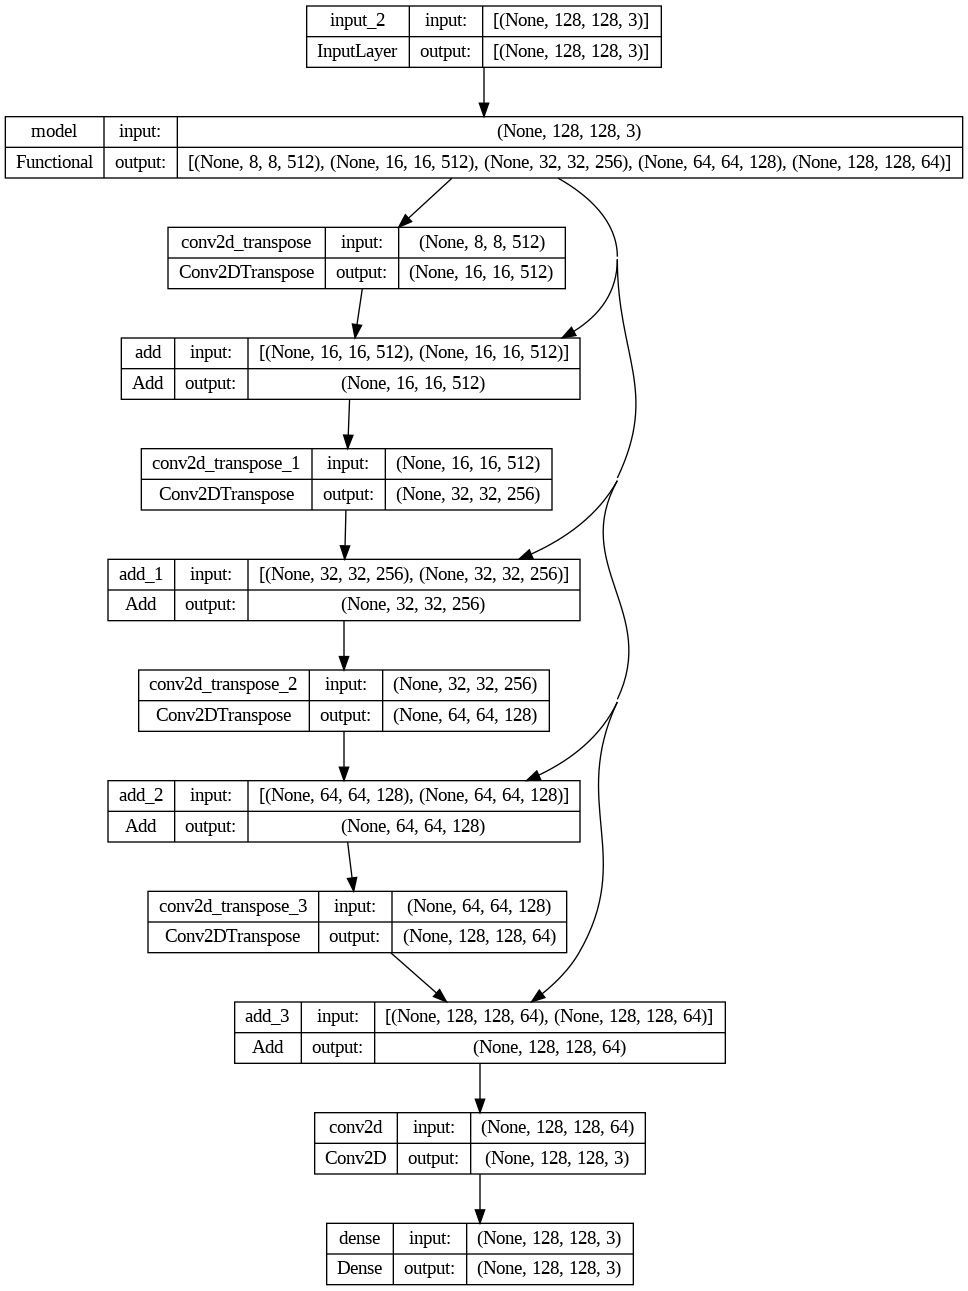

In [14]:
# 모델 구조 시각화
tf.keras.utils.plot_model(unet_model, show_shapes=True)

In [15]:
# 모델 요약
unet_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 model (Functional)          [(None, 8, 8, 512),          1471468   ['input_2[0][0]']             
                              (None, 16, 16, 512),        8                                       
                              (None, 32, 32, 256),                                                
                              (None, 64, 64, 128),                                                
                              (None, 128, 128, 64)]                                               
                                                                                            

In [16]:
# 모델 컴파일 및 훈련
loss_f = tf.losses.SparseCategoricalCrossentropy()
opt = tf.optimizers.Adam(learning_rate)

unet_model.compile(optimizer=opt, loss=loss_f, metrics=['accuracy'])
unet_model.fit(train_ds, batch_size=batch_size,epochs=epoch_num)

Epoch 1/3
230/230 [==============================] - 1347s 6s/step - loss: 0.7867 - accuracy: 0.7256
Epoch 2/3
230/230 [==============================] - 1279s 6s/step - loss: 0.6443 - accuracy: 0.8026
Epoch 3/3
230/230 [==============================] - 1272s 6s/step - loss: 0.5878 - accuracy: 0.8234


1/1 [==============================] - 4s 4s/step


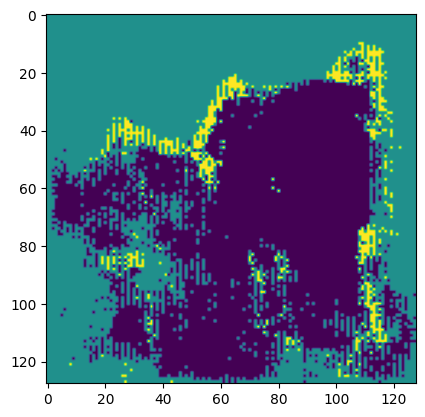

In [17]:
# 1개 배치(16개 이미지)를 선택
img, mask = next(iter(test_ds))

# 모델 예측
pred = unet_model.predict(img)

# 첫번째 이미지 분할 결과를 출력
pred_img = np.argmax(pred[0], -1)
plt.imshow(pred_img)

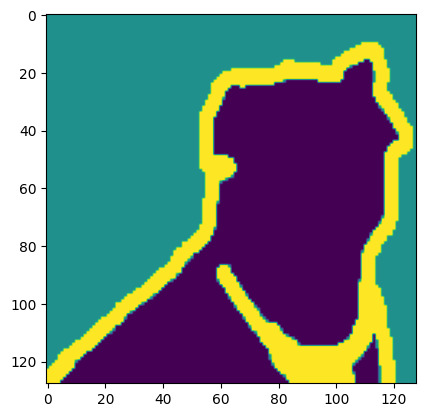

In [18]:
# 첫 번째 이미지의 정답 마스크 출력
plt.imshow(np.reshape(mask[0],(128,128))) # 어느 정도 객체의 경계를 찾아냄